In [1]:
# Import all libraries
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [2]:
# Define emotion labels based on your mapping
emotion_labels = {0: "Happy", 1: "Surprise", 2: "Sad", 3: "Anger", 4: "Disgust", 5: "Fear", 6: "Neutral"}

# Step 1: Load and Preprocess RAF-DB Dataset
class RAFDBDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        # RAF-DB classes: 1=Surprise, 2=Fear, 3=Disgust, 4=Happy, 5=Sad, 6=Anger, 7=Neutral
        # Desired mapping: Happy=0, Surprise=1, Sad=2, Anger=3, Disgust=4, Fear=5, Neutral=6
        self.label_map = {
            1: 1, 
            2: 5,
            3: 4,
            4: 0,
            5: 2,
            6: 3,
            7: 6
        }

        # Dynamically load images and labels from folder structure
        self.image_data = []
        for class_folder in os.listdir(img_dir):
            class_path = os.path.join(img_dir, class_folder)
            if os.path.isdir(class_path) and class_folder.isdigit():
                label = int(class_folder)  # Get RAF-DB label (1-7) from folder name
                if label in self.label_map:
                    for filename in os.listdir(class_path):
                        if filename.endswith(".jpg") or filename.endswith(".png"):
                            self.image_data.append([filename, label])

        if not self.image_data:
            raise ValueError(f"No images found in {img_dir}")

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img_name, original_rafdb_label = self.image_data[idx]
        # Map RAF-DB label (1-7) to desired label (0-6)
        mapped_label = self.label_map[original_rafdb_label]
        # Construct image path using the original RAF-DB label (folder name)
        img_path = os.path.join(self.img_dir, str(original_rafdb_label), img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, mapped_label

# Define enhanced transforms for training with additional augmentations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.RandomHorizontalFlip(),                    # Horizontal flip
    transforms.RandomRotation(10),                        # Random rotation ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color adjustments
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),    # Random affine transformations
    transforms.Grayscale(num_output_channels=3),          # Convert to grayscale
    transforms.ToTensor(),                                # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize
])

# Define minimal transforms for testing
test_transforms = transforms.Compose([
    transforms.Resize((100, 100)),                          # Resize to 64x64
    transforms.Grayscale(num_output_channels=3),          # Convert to grayscale
    transforms.ToTensor(),                                # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize
])

# Load datasets with appropriate transforms
base_path = "/kaggle/input/raf-db-dataset"
train_img_dir = os.path.join(base_path, "DATASET/train")
test_img_dir = os.path.join(base_path, "DATASET/test")

# Check if dataset paths exist (optional, for debugging)
if not os.path.exists(train_img_dir):
    print(f"Warning: Training image directory not found at {train_img_dir}")
if not os.path.exists(test_img_dir):
    print(f"Warning: Test image directory not found at {test_img_dir}")

train_dataset = RAFDBDataset(
    img_dir=train_img_dir,
    transform=train_transforms  # Use augmented transforms for training
)
test_dataset = RAFDBDataset(
    img_dir=test_img_dir,
    transform=test_transforms   # Use minimal transforms for testing
)

# Print the number of images in train and test sets
print(f"Number of images in the train set: {len(train_dataset)}")
print(f"Number of images in the test set: {len(test_dataset)}")

# Check class distribution in the training set
train_original_labels = [item[1] for item in train_dataset.image_data]
train_class_counts = pd.Series(train_original_labels).value_counts().sort_index()
print("\nTraining set class distribution (Original RAF-DB labels 1-7 mapped to target emotion names):")
for original_label, count in train_class_counts.items():
    mapped_label_idx = train_dataset.label_map[original_label]
    emotion_name = emotion_labels[mapped_label_idx]
    print(f"Original Class {original_label} ({emotion_name}): {count} images")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count() if os.cpu_count() <= 4 else 4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count() if os.cpu_count() <= 4 else 4)

# Print shapes of one batch from each loader
train_image, train_label = next(iter(train_loader))
print(f"\nTrain batch: Image shape {train_image.shape}, Label shape {train_label.shape}")

test_image, test_label = next(iter(test_loader))
print(f"Test batch: Image shape {test_image.shape}, Label shape {test_label.shape}")


Number of images in the train set: 12271
Number of images in the test set: 3068

Training set class distribution (Original RAF-DB labels 1-7 mapped to target emotion names):
Original Class 1 (Surprise): 1290 images
Original Class 2 (Fear): 281 images
Original Class 3 (Disgust): 717 images
Original Class 4 (Happy): 4772 images
Original Class 5 (Sad): 1982 images
Original Class 6 (Anger): 705 images
Original Class 7 (Neutral): 2524 images

Train batch: Image shape torch.Size([32, 3, 100, 100]), Label shape torch.Size([32])
Test batch: Image shape torch.Size([32, 3, 100, 100]), Label shape torch.Size([32])


Number of images processed in this batch: 32
Number of images displayed: 8


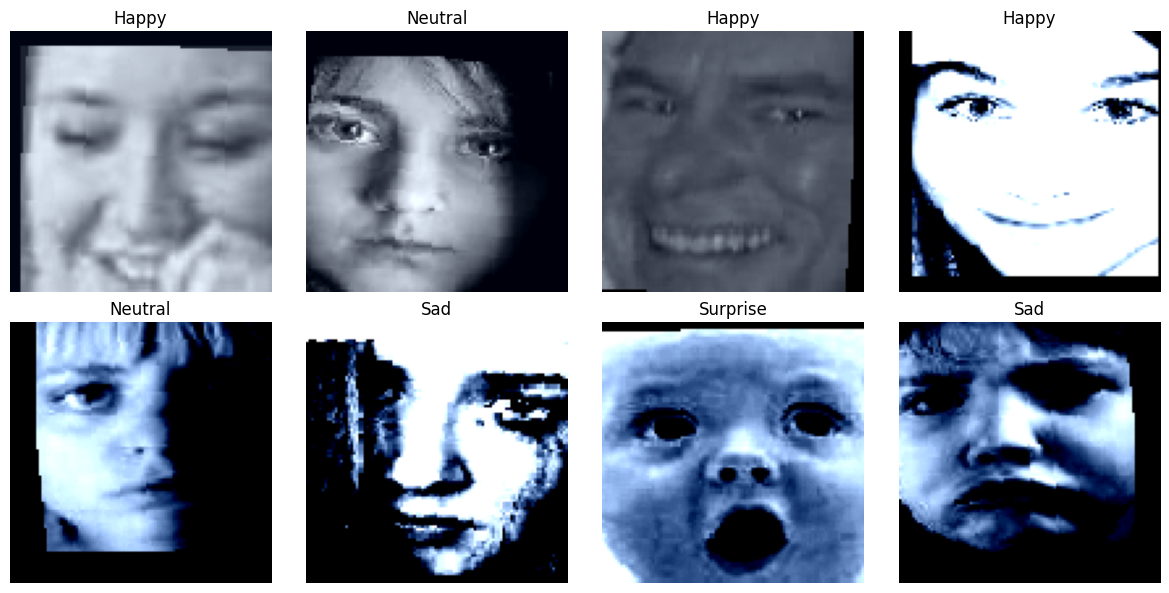

In [3]:
# After augmentation
# Function to denormalize images for visualization
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization: (tensor * std) + mean
    return tensor

# Get a batch of training images
images, labels = next(iter(train_loader))

# Denormalize images for visualization
images = denormalize(images)

# Print the number of images in the batch
print(f"Number of images processed in this batch: {images.shape[0]}")
print(f"Number of images displayed: 8")

# Plot the first 8 images in the batch
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    img = images[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    img = np.clip(img, 0, 1)  # Ensure pixel values are in [0, 1]
    axes[i].imshow(img)  # Since images are grayscale with 3 channels, this will show as grayscale
    axes[i].set_title(emotion_labels[labels[i].item()])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Step 1: Define Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Step 2: Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

# Step 3: Define ResEmoteNet with SE Blocks
class ResEmoteNet(nn.Module):
    def __init__(self, num_classes=7):
        super(ResEmoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.se = SEBlock(256)

        self.res_block1 = ResidualBlock(256, 512, stride=2)
        self.res_block2 = ResidualBlock(512, 1024, stride=2)
        self.res_block3 = ResidualBlock(1024, 2048, stride=2)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        x = self.se(x)

        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        x = self.pool(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

# Step 4: Initialize Device, Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResEmoteNet(num_classes=7).to(device)

# Step 5: Print total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")

# Step 6: Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Step 7: Checkpoint Management
checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

start_epoch = 0
best_acc = 0.0
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

train_losses, val_losses = [], []
train_accs, val_accs = [], []

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_acc = checkpoint['best_acc']
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_accs = checkpoint.get('train_accs', [])
    val_accs = checkpoint.get('val_accs', [])

    print(f"Resumed training from epoch {start_epoch} with best accuracy {best_acc:.2f}%")


80,238,599 total parameters.


In [5]:
# Step 4: Train the Model
patience = 15
epochs_no_improve = 0
early_stop = False

num_epochs = 100
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # Use enumerate for batch count
    train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=True)
    for batch_idx, (images, labels) in train_progress:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1) # use .data to avoid graph issues if any, though not strictly necessary here
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Corrected postfix: average loss over batches processed so far
        train_progress.set_postfix({'loss': running_loss / (batch_idx + 1)})
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_running_loss = 0.0 # Use different variable name to avoid confusion
    val_correct = 0
    val_total = 0
    val_progress = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
    with torch.no_grad():
        for batch_idx, (images, labels) in val_progress:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_progress.set_postfix({'loss': val_running_loss / (batch_idx + 1)})
            
    val_loss = val_running_loss / len(test_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_acc': best_acc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }
    torch.save(checkpoint, checkpoint_path)

    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0  # Reset counter if improvement
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
        print(f"Saved best model with Val Acc: {best_acc:.2f}%")
    else:
        epochs_no_improve += 1
        print(f"No improvement in Val Acc for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            early_stop = True
            break

Epoch 1/100 [Training]: 100%|██████████| 384/384 [00:43<00:00,  8.84it/s, loss=1.68]


Epoch [1/100], Train Loss: 1.6828, Train Acc: 37.71%, Val Loss: 1.6110, Val Acc: 38.62%
Saved best model with Val Acc: 38.62%


Epoch 2/100 [Training]: 100%|██████████| 384/384 [00:45<00:00,  8.36it/s, loss=1.61]


Epoch [2/100], Train Loss: 1.6106, Train Acc: 38.88%, Val Loss: 1.5596, Val Acc: 38.59%
No improvement in Val Acc for 1 epochs.


Epoch 3/100 [Training]: 100%|██████████| 384/384 [00:50<00:00,  7.63it/s, loss=1.57]


Epoch [3/100], Train Loss: 1.5681, Train Acc: 39.57%, Val Loss: 1.4622, Val Acc: 44.23%
Saved best model with Val Acc: 44.23%


Epoch 4/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.84it/s, loss=1.51]


Epoch [4/100], Train Loss: 1.5078, Train Acc: 43.45%, Val Loss: 1.4549, Val Acc: 43.48%
No improvement in Val Acc for 1 epochs.


Epoch 5/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.80it/s, loss=1.44]


Epoch [5/100], Train Loss: 1.4446, Train Acc: 45.86%, Val Loss: 1.3894, Val Acc: 46.61%
Saved best model with Val Acc: 46.61%


Epoch 6/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.76it/s, loss=1.39]


Epoch [6/100], Train Loss: 1.3924, Train Acc: 48.23%, Val Loss: 1.3801, Val Acc: 47.95%
Saved best model with Val Acc: 47.95%


Epoch 7/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.75it/s, loss=1.35]


Epoch [7/100], Train Loss: 1.3509, Train Acc: 50.07%, Val Loss: 1.2887, Val Acc: 52.77%
Saved best model with Val Acc: 52.77%


Epoch 8/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.78it/s, loss=1.3] 


Epoch [8/100], Train Loss: 1.3042, Train Acc: 52.13%, Val Loss: 1.2472, Val Acc: 53.26%
Saved best model with Val Acc: 53.26%


Epoch 9/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.74it/s, loss=1.28]


Epoch [9/100], Train Loss: 1.2814, Train Acc: 53.14%, Val Loss: 1.2623, Val Acc: 52.97%
No improvement in Val Acc for 1 epochs.


Epoch 10/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.82it/s, loss=1.24]


Epoch [10/100], Train Loss: 1.2377, Train Acc: 55.00%, Val Loss: 1.1484, Val Acc: 57.43%
Saved best model with Val Acc: 57.43%


Epoch 11/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.75it/s, loss=1.21]


Epoch [11/100], Train Loss: 1.2132, Train Acc: 55.64%, Val Loss: 1.1289, Val Acc: 58.38%
Saved best model with Val Acc: 58.38%


Epoch 12/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.76it/s, loss=1.18]


Epoch [12/100], Train Loss: 1.1806, Train Acc: 57.11%, Val Loss: 1.0649, Val Acc: 61.41%
Saved best model with Val Acc: 61.41%


Epoch 13/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.81it/s, loss=1.15]


Epoch [13/100], Train Loss: 1.1544, Train Acc: 58.18%, Val Loss: 1.1093, Val Acc: 59.26%
No improvement in Val Acc for 1 epochs.


Epoch 14/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.76it/s, loss=1.13]


Epoch [14/100], Train Loss: 1.1303, Train Acc: 58.87%, Val Loss: 0.9905, Val Acc: 65.51%
Saved best model with Val Acc: 65.51%


Epoch 15/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.73it/s, loss=1.1] 


Epoch [15/100], Train Loss: 1.0992, Train Acc: 60.74%, Val Loss: 1.0600, Val Acc: 62.32%
No improvement in Val Acc for 1 epochs.


Epoch 16/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.79it/s, loss=1.07]


Epoch [16/100], Train Loss: 1.0694, Train Acc: 62.03%, Val Loss: 0.9730, Val Acc: 65.94%
Saved best model with Val Acc: 65.94%


Epoch 17/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.75it/s, loss=1.03]


Epoch [17/100], Train Loss: 1.0346, Train Acc: 63.21%, Val Loss: 0.9631, Val Acc: 65.68%
No improvement in Val Acc for 1 epochs.


Epoch 18/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.81it/s, loss=1.02]


Epoch [18/100], Train Loss: 1.0221, Train Acc: 63.77%, Val Loss: 0.9945, Val Acc: 63.95%
No improvement in Val Acc for 2 epochs.


Epoch 19/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.76it/s, loss=0.996]


Epoch [19/100], Train Loss: 0.9960, Train Acc: 64.51%, Val Loss: 0.9357, Val Acc: 66.23%
Saved best model with Val Acc: 66.23%


Epoch 20/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.77it/s, loss=0.97] 


Epoch [20/100], Train Loss: 0.9703, Train Acc: 65.44%, Val Loss: 0.8118, Val Acc: 70.89%
Saved best model with Val Acc: 70.89%


Epoch 21/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.74it/s, loss=0.953]


Epoch [21/100], Train Loss: 0.9525, Train Acc: 66.49%, Val Loss: 0.8639, Val Acc: 68.64%
No improvement in Val Acc for 1 epochs.


Epoch 22/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.79it/s, loss=0.932]


Epoch [22/100], Train Loss: 0.9323, Train Acc: 67.19%, Val Loss: 0.8370, Val Acc: 69.30%
No improvement in Val Acc for 2 epochs.


Epoch 23/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.75it/s, loss=0.926]


Epoch [23/100], Train Loss: 0.9260, Train Acc: 67.13%, Val Loss: 0.8707, Val Acc: 68.71%
No improvement in Val Acc for 3 epochs.


Epoch 24/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.73it/s, loss=0.907]


Epoch [24/100], Train Loss: 0.9073, Train Acc: 68.07%, Val Loss: 0.8961, Val Acc: 67.63%
No improvement in Val Acc for 4 epochs.


Epoch 25/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.77it/s, loss=0.886]


Epoch [25/100], Train Loss: 0.8856, Train Acc: 68.81%, Val Loss: 0.7551, Val Acc: 72.39%
Saved best model with Val Acc: 72.39%


Epoch 26/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.74it/s, loss=0.874]


Epoch [26/100], Train Loss: 0.8742, Train Acc: 69.59%, Val Loss: 0.8069, Val Acc: 71.38%
No improvement in Val Acc for 1 epochs.


Epoch 27/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.79it/s, loss=0.865]


Epoch [27/100], Train Loss: 0.8646, Train Acc: 69.48%, Val Loss: 0.7790, Val Acc: 72.59%
Saved best model with Val Acc: 72.59%


Epoch 28/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.74it/s, loss=0.86] 


Epoch [28/100], Train Loss: 0.8597, Train Acc: 70.08%, Val Loss: 0.8792, Val Acc: 65.38%
No improvement in Val Acc for 1 epochs.


Epoch 29/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.78it/s, loss=0.837]


Epoch [29/100], Train Loss: 0.8368, Train Acc: 70.28%, Val Loss: 0.8032, Val Acc: 71.12%
No improvement in Val Acc for 2 epochs.


Epoch 30/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.75it/s, loss=0.827]


Epoch [30/100], Train Loss: 0.8272, Train Acc: 71.48%, Val Loss: 0.7558, Val Acc: 71.09%
No improvement in Val Acc for 3 epochs.


Epoch 31/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.78it/s, loss=0.81] 


Epoch [31/100], Train Loss: 0.8097, Train Acc: 71.58%, Val Loss: 0.6912, Val Acc: 76.08%
Saved best model with Val Acc: 76.08%


Epoch 32/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.75it/s, loss=0.813]


Epoch [32/100], Train Loss: 0.8134, Train Acc: 71.27%, Val Loss: 0.8469, Val Acc: 68.51%
No improvement in Val Acc for 1 epochs.


Epoch 33/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.83it/s, loss=0.793]


Epoch [33/100], Train Loss: 0.7930, Train Acc: 72.23%, Val Loss: 0.6861, Val Acc: 76.04%
No improvement in Val Acc for 2 epochs.


Epoch 34/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.77it/s, loss=0.785]


Epoch [34/100], Train Loss: 0.7848, Train Acc: 72.65%, Val Loss: 0.7785, Val Acc: 72.49%
No improvement in Val Acc for 3 epochs.


Epoch 35/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.78it/s, loss=0.78] 


Epoch [35/100], Train Loss: 0.7798, Train Acc: 72.69%, Val Loss: 0.7679, Val Acc: 72.59%
No improvement in Val Acc for 4 epochs.


Epoch 36/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.76it/s, loss=0.778]


Epoch [36/100], Train Loss: 0.7783, Train Acc: 72.37%, Val Loss: 0.7685, Val Acc: 72.29%
No improvement in Val Acc for 5 epochs.


Epoch 37/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.72it/s, loss=0.757]


Epoch [37/100], Train Loss: 0.7574, Train Acc: 73.04%, Val Loss: 0.6533, Val Acc: 76.99%
Saved best model with Val Acc: 76.99%


Epoch 38/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.75it/s, loss=0.752]


Epoch [38/100], Train Loss: 0.7521, Train Acc: 73.21%, Val Loss: 0.7654, Val Acc: 73.40%
No improvement in Val Acc for 1 epochs.


Epoch 39/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.76it/s, loss=0.743]


Epoch [39/100], Train Loss: 0.7431, Train Acc: 74.17%, Val Loss: 0.7041, Val Acc: 74.35%
No improvement in Val Acc for 2 epochs.


Epoch 40/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.73it/s, loss=0.726]


Epoch [40/100], Train Loss: 0.7261, Train Acc: 74.88%, Val Loss: 0.7096, Val Acc: 74.80%
No improvement in Val Acc for 3 epochs.


Epoch 41/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.78it/s, loss=0.718]


Epoch [41/100], Train Loss: 0.7184, Train Acc: 75.09%, Val Loss: 0.7248, Val Acc: 73.83%
No improvement in Val Acc for 4 epochs.


Epoch 42/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.74it/s, loss=0.712]


Epoch [42/100], Train Loss: 0.7116, Train Acc: 74.92%, Val Loss: 0.7720, Val Acc: 72.78%
No improvement in Val Acc for 5 epochs.


Epoch 43/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.77it/s, loss=0.711]


Epoch [43/100], Train Loss: 0.7114, Train Acc: 75.09%, Val Loss: 0.7206, Val Acc: 74.51%
No improvement in Val Acc for 6 epochs.


Epoch 44/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.73it/s, loss=0.704]


Epoch [44/100], Train Loss: 0.7045, Train Acc: 75.06%, Val Loss: 0.6851, Val Acc: 76.27%
No improvement in Val Acc for 7 epochs.


Epoch 45/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.79it/s, loss=0.7]  


Epoch [45/100], Train Loss: 0.7003, Train Acc: 75.76%, Val Loss: 0.6796, Val Acc: 75.55%
No improvement in Val Acc for 8 epochs.


Epoch 46/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.75it/s, loss=0.675]


Epoch [46/100], Train Loss: 0.6751, Train Acc: 76.28%, Val Loss: 0.6563, Val Acc: 76.96%
No improvement in Val Acc for 9 epochs.


Epoch 47/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.76it/s, loss=0.684]


Epoch [47/100], Train Loss: 0.6836, Train Acc: 75.92%, Val Loss: 0.7316, Val Acc: 73.17%
No improvement in Val Acc for 10 epochs.


Epoch 48/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.74it/s, loss=0.673]


Epoch [48/100], Train Loss: 0.6733, Train Acc: 76.12%, Val Loss: 0.6861, Val Acc: 75.65%
No improvement in Val Acc for 11 epochs.


Epoch 49/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.78it/s, loss=0.666]


Epoch [49/100], Train Loss: 0.6662, Train Acc: 76.83%, Val Loss: 0.6147, Val Acc: 78.88%
Saved best model with Val Acc: 78.88%


Epoch 50/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.75it/s, loss=0.662]


Epoch [50/100], Train Loss: 0.6620, Train Acc: 76.95%, Val Loss: 0.5839, Val Acc: 79.73%
Saved best model with Val Acc: 79.73%


Epoch 51/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.80it/s, loss=0.652]


Epoch [51/100], Train Loss: 0.6515, Train Acc: 77.13%, Val Loss: 0.7040, Val Acc: 75.78%
No improvement in Val Acc for 1 epochs.


Epoch 52/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.75it/s, loss=0.654]


Epoch [52/100], Train Loss: 0.6539, Train Acc: 77.00%, Val Loss: 0.5868, Val Acc: 80.12%
Saved best model with Val Acc: 80.12%


Epoch 53/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.78it/s, loss=0.649]


Epoch [53/100], Train Loss: 0.6494, Train Acc: 76.95%, Val Loss: 0.7300, Val Acc: 73.47%
No improvement in Val Acc for 1 epochs.


Epoch 54/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.74it/s, loss=0.636]


Epoch [54/100], Train Loss: 0.6365, Train Acc: 77.72%, Val Loss: 0.6176, Val Acc: 79.14%
No improvement in Val Acc for 2 epochs.


Epoch 55/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.74it/s, loss=0.63] 


Epoch [55/100], Train Loss: 0.6296, Train Acc: 78.04%, Val Loss: 0.7040, Val Acc: 75.42%
No improvement in Val Acc for 3 epochs.


Epoch 56/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.73it/s, loss=0.629]


Epoch [56/100], Train Loss: 0.6294, Train Acc: 77.86%, Val Loss: 0.6046, Val Acc: 79.50%
No improvement in Val Acc for 4 epochs.


Epoch 57/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.80it/s, loss=0.624]


Epoch [57/100], Train Loss: 0.6240, Train Acc: 78.45%, Val Loss: 0.6214, Val Acc: 79.27%
No improvement in Val Acc for 5 epochs.


Epoch 58/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.77it/s, loss=0.611]


Epoch [58/100], Train Loss: 0.6109, Train Acc: 78.49%, Val Loss: 0.6281, Val Acc: 78.81%
No improvement in Val Acc for 6 epochs.


Epoch 59/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.72it/s, loss=0.603]


Epoch [59/100], Train Loss: 0.6026, Train Acc: 78.51%, Val Loss: 0.6043, Val Acc: 79.40%
No improvement in Val Acc for 7 epochs.


Epoch 60/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.71it/s, loss=0.609]


Epoch [60/100], Train Loss: 0.6092, Train Acc: 78.62%, Val Loss: 0.6218, Val Acc: 78.98%
No improvement in Val Acc for 8 epochs.


Epoch 61/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.74it/s, loss=0.593]


Epoch [61/100], Train Loss: 0.5929, Train Acc: 79.80%, Val Loss: 0.5864, Val Acc: 80.44%
Saved best model with Val Acc: 80.44%


Epoch 62/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.75it/s, loss=0.596]


Epoch [62/100], Train Loss: 0.5965, Train Acc: 79.20%, Val Loss: 0.6381, Val Acc: 78.29%
No improvement in Val Acc for 1 epochs.


Epoch 63/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.77it/s, loss=0.581]


Epoch [63/100], Train Loss: 0.5814, Train Acc: 79.55%, Val Loss: 0.6171, Val Acc: 79.60%
No improvement in Val Acc for 2 epochs.


Epoch 64/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.74it/s, loss=0.575]


Epoch [64/100], Train Loss: 0.5752, Train Acc: 79.72%, Val Loss: 0.6005, Val Acc: 79.86%
No improvement in Val Acc for 3 epochs.


Epoch 65/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.75it/s, loss=0.574]


Epoch [65/100], Train Loss: 0.5739, Train Acc: 79.83%, Val Loss: 0.6057, Val Acc: 79.89%
No improvement in Val Acc for 4 epochs.


Epoch 66/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.74it/s, loss=0.569]


Epoch [66/100], Train Loss: 0.5689, Train Acc: 79.46%, Val Loss: 0.5801, Val Acc: 79.76%
No improvement in Val Acc for 5 epochs.


Epoch 67/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.72it/s, loss=0.569]


Epoch [67/100], Train Loss: 0.5687, Train Acc: 80.26%, Val Loss: 0.6030, Val Acc: 79.34%
No improvement in Val Acc for 6 epochs.


Epoch 68/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.77it/s, loss=0.565]


Epoch [68/100], Train Loss: 0.5648, Train Acc: 79.85%, Val Loss: 0.5525, Val Acc: 81.06%
Saved best model with Val Acc: 81.06%


Epoch 69/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.73it/s, loss=0.548]


Epoch [69/100], Train Loss: 0.5484, Train Acc: 80.82%, Val Loss: 0.5940, Val Acc: 79.66%
No improvement in Val Acc for 1 epochs.


Epoch 70/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.76it/s, loss=0.557]


Epoch [70/100], Train Loss: 0.5571, Train Acc: 80.60%, Val Loss: 0.6610, Val Acc: 77.97%
No improvement in Val Acc for 2 epochs.


Epoch 71/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.76it/s, loss=0.552]


Epoch [71/100], Train Loss: 0.5524, Train Acc: 80.82%, Val Loss: 0.6460, Val Acc: 78.36%
No improvement in Val Acc for 3 epochs.


Epoch 72/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.73it/s, loss=0.536]


Epoch [72/100], Train Loss: 0.5364, Train Acc: 81.41%, Val Loss: 0.7439, Val Acc: 75.20%
No improvement in Val Acc for 4 epochs.


Epoch 73/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.72it/s, loss=0.546]


Epoch [73/100], Train Loss: 0.5458, Train Acc: 80.75%, Val Loss: 0.5964, Val Acc: 79.82%
No improvement in Val Acc for 5 epochs.


Epoch 74/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.78it/s, loss=0.526]


Epoch [74/100], Train Loss: 0.5262, Train Acc: 81.48%, Val Loss: 0.5933, Val Acc: 79.89%
No improvement in Val Acc for 6 epochs.


Epoch 75/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.75it/s, loss=0.542]


Epoch [75/100], Train Loss: 0.5416, Train Acc: 81.03%, Val Loss: 0.5704, Val Acc: 80.74%
No improvement in Val Acc for 7 epochs.


Epoch 76/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.72it/s, loss=0.509]


Epoch [76/100], Train Loss: 0.5094, Train Acc: 82.09%, Val Loss: 0.6564, Val Acc: 78.26%
No improvement in Val Acc for 8 epochs.


Epoch 77/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.72it/s, loss=0.524]


Epoch [77/100], Train Loss: 0.5244, Train Acc: 81.46%, Val Loss: 0.5913, Val Acc: 80.90%
No improvement in Val Acc for 9 epochs.


Epoch 78/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.72it/s, loss=0.524]


Epoch [78/100], Train Loss: 0.5238, Train Acc: 81.75%, Val Loss: 0.6296, Val Acc: 79.20%
No improvement in Val Acc for 10 epochs.


Epoch 79/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.72it/s, loss=0.514]


Epoch [79/100], Train Loss: 0.5142, Train Acc: 82.18%, Val Loss: 0.6490, Val Acc: 78.65%
No improvement in Val Acc for 11 epochs.


Epoch 80/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.73it/s, loss=0.513]


Epoch [80/100], Train Loss: 0.5125, Train Acc: 81.88%, Val Loss: 0.5970, Val Acc: 80.18%
No improvement in Val Acc for 12 epochs.


Epoch 81/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.72it/s, loss=0.506]


Epoch [81/100], Train Loss: 0.5062, Train Acc: 81.78%, Val Loss: 0.6807, Val Acc: 76.89%
No improvement in Val Acc for 13 epochs.


Epoch 82/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.74it/s, loss=0.5]  


Epoch [82/100], Train Loss: 0.4999, Train Acc: 82.38%, Val Loss: 0.5734, Val Acc: 80.18%
No improvement in Val Acc for 14 epochs.


Epoch 83/100 [Training]: 100%|██████████| 384/384 [00:49<00:00,  7.74it/s, loss=0.504]


Epoch [83/100], Train Loss: 0.5044, Train Acc: 82.03%, Val Loss: 0.5868, Val Acc: 80.18%
No improvement in Val Acc for 15 epochs.
Early stopping triggered.


In [6]:
# Step 5: Save Final Model
torch.save(model.state_dict(), "/kaggle/working/final_model.pth")
print("Saved final model state to /kaggle/working/final_model.pth")

Saved final model state to /kaggle/working/final_model.pth


In [7]:
# Step 6: Evaluate Model
# Load the best model for evaluation
if os.path.exists("/kaggle/working/best_model.pth"):
    model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))
    print("Loaded best model for evaluation.")
else:
    print("Best model not found. Evaluating with the final model.")
    # If best_model.pth doesn't exist (e.g. training for 0 epochs or never improved), 
    # model already has final weights. Or load final_model.pth if script was restarted.
    if os.path.exists("/kaggle/working/final_model.pth"):
         model.load_state_dict(torch.load("/kaggle/working/final_model.pth", map_location=device))
    else:
        print("No saved model found for evaluation.")


model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

if total > 0:
    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
else:
    print("Test set is empty or not loaded correctly. Cannot compute accuracy.")
    test_acc = 0.0 # Default value

Loaded best model for evaluation.


Evaluating on Test Set: 100%|██████████| 96/96 [00:03<00:00, 29.22it/s]

Test Accuracy: 81.06%


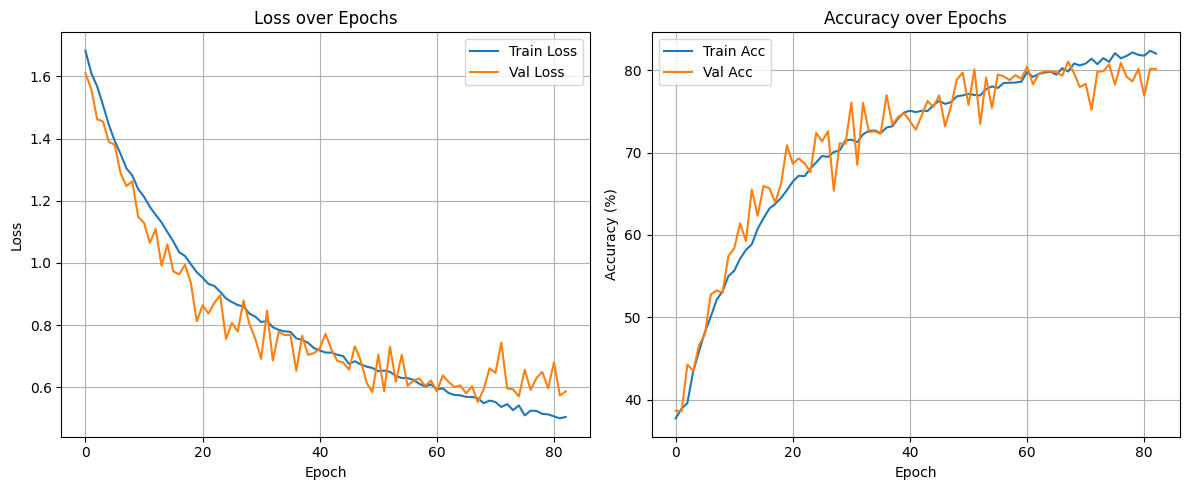

Saved training curves to /kaggle/working/training_curves.png


In [8]:
# Step 7: Plot Training Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("/kaggle/working/training_curves.png")
plt.show()
print("Saved training curves to /kaggle/working/training_curves.png")

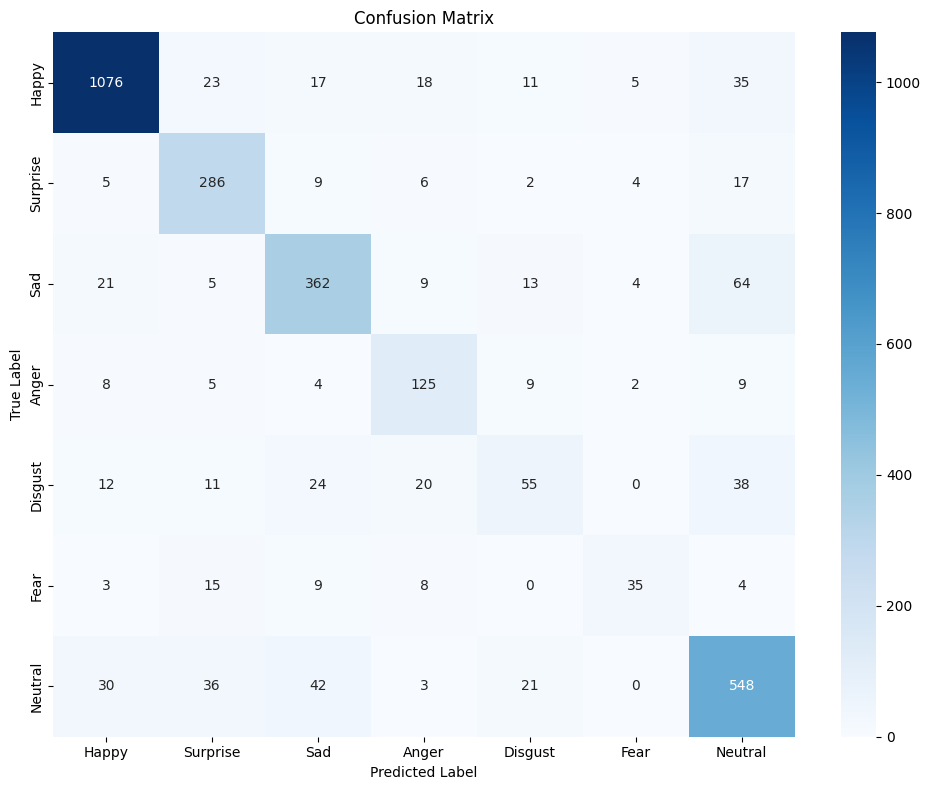

Saved confusion matrix to /kaggle/working/confusion_matrix.png


In [9]:
# Step 8: Confusion Matrix with Emotion Labels
if all_labels and all_preds: # Ensure lists are not empty
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8)) # Increased size for better readability
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=[emotion_labels[i] for i in range(len(emotion_labels))], 
                yticklabels=[emotion_labels[i] for i in range(len(emotion_labels))])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig("/kaggle/working/confusion_matrix.png")
    plt.show()
    print("Saved confusion matrix to /kaggle/working/confusion_matrix.png")
else:
    print("No labels/predictions available for confusion matrix (e.g., test set was empty or evaluation skipped).")